In [ ]:
import tensorflow as tf

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

## Data preprocessing and data augmentation

What is different about [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) is that we can submit images directly to the input. However, these images also require pre-processing.

In particular, it is necessary to normalize the pixels color, i.e. to normalize them from the range [0, 255) to [0, 1).

You also need to change the dimension of the input images because of Keras framework.

Image classes should be of numeric type instead of string.

The code below makes the necessary transformations.


In [ ]:
IMM_SIZE = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data(directory):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_directory(directory,
                                       target_size=(224, 224),
                                       batch_size=32,
                                       class_mode='categorical')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
d = "/content/drive/MyDrive/Covid19-dataset/train"
train = get_data(d)

d = "/content/drive/MyDrive/Covid19-dataset/test"
val = get_data(d)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
print("Train size:", train.samples)
print("Test size:", val.samples)


images, labels = train[0]  # Get the first batch
print("Image batch shape:", images.shape)  # (batch_size, height, width, channels)
print("Label batch shape:", labels.shape)


Train size: 251
Test size: 66
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


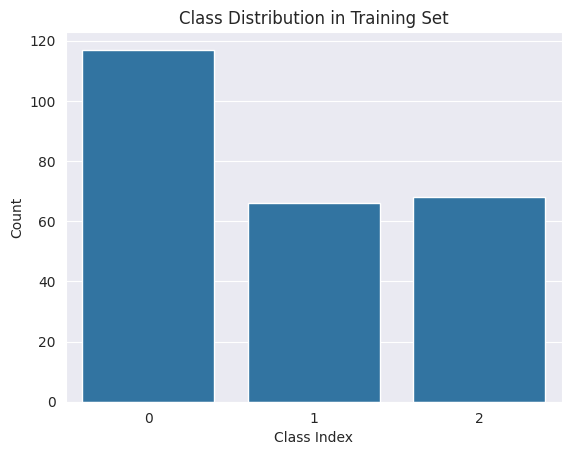

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all labels from batches
labels = []

for batch in train:
    batch_labels = np.argmax(batch[1], axis=1)  # Convert one-hot to class index
    labels.extend(batch_labels)

    if len(labels) >= train.samples:
        break  # Prevent looping over the data generator more than once

# Plot using seaborn
sns.set_style('darkgrid')
sns.countplot(x=labels)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

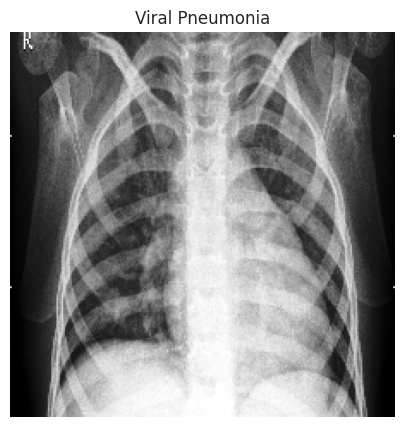

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# First, get the class index for 'Viral Pneumonia'
class_indices = train.class_indices
target_class = 'Viral Pneumonia'
target_index = class_indices[target_class]

# Loop over batches to find an image of the desired class
for images, labels in train:
    indices = np.argmax(labels, axis=1)
    if target_index in indices:
        idx = np.where(indices == target_index)[0][0]
        img = images[idx]
        break

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title('Viral Pneumonia')
plt.axis('off')
plt.show()


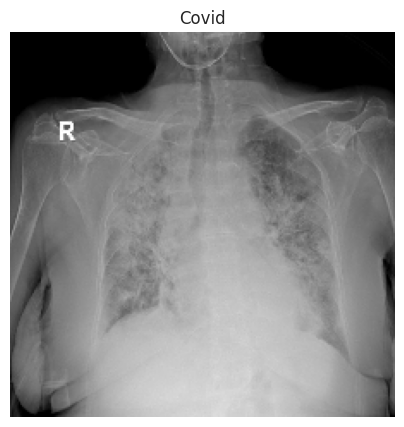

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class index for 'Covid'
class_indices = train.class_indices  # e.g., {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
target_class = 'Covid'
target_index = class_indices[target_class]

# Search for an image with the desired label
for images, labels in train:
    label_indices = np.argmax(labels, axis=1)
    if target_index in label_indices:
        img_index = np.where(label_indices == target_index)[0][0]
        img = images[img_index]
        break  # Stop after finding the first matching image

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title('Covid')
plt.axis('off')
plt.show()

In [ ]:
def create_features(data):
    features = []
    labels = []
    for image, label in data:
        features.append(mh.features.haralick(image).ravel())
        labels.append(label)
    features = np.array(features)
    labels = np.array(labels)
    return (features, labels)

In [ ]:
import numpy as np

def create_features(generator):
    features = []
    labels = []

    for images, batch_labels in generator:
        features.append(images)
        labels.append(batch_labels)

        # Stop when we've collected all samples
        if len(features) * generator.batch_size >= generator.samples:
            break

    # Combine into arrays
    features = np.vstack(features)
    labels = np.vstack(labels)

    return features, labels


features_train, labels_train = create_features(train)
features_test, labels_test = create_features(val)

print("Train Features:", features_train.shape)
print("Train Labels:", labels_train.shape)


Train Features: (251, 224, 224, 3)
Train Labels: (251, 3)


In [ ]:
import numpy as np

x_train = []
y_train = []
x_val = []
y_val = []

# Assuming your images are already rescaled by ImageDataGenerator(rescale=1./255)
for features, labels in train:
    x_train.append(features)
    y_train.append(np.argmax(labels, axis=1))  # Convert one-hot to class index

    if len(x_train) * train.batch_size >= train.samples:
        break

for features, labels in val:
    x_val.append(features)
    y_val.append(np.argmax(labels, axis=1))

    if len(x_val) * val.batch_size >= val.samples:
        break

# Convert to arrays
x_train = np.vstack(x_train)
x_val = np.vstack(x_val)
y_train = np.concatenate(y_train)
y_val = np.concatenate(y_val)

# Reshape to (N, H, W, 1) for grayscale, if needed
IMM_SIZE = x_train.shape[1]  # or set manually, like 224
x_train = x_train.reshape(-1, IMM_SIZE, IMM_SIZE, 1)
x_val = x_val.reshape(-1, IMM_SIZE, IMM_SIZE, 1)

# Optional: print class mapping
class_indices = train.class_indices
print("Class label mapping:", class_indices)

Class label mapping: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
print("Shape of the input DataSet:", x_train.shape)
print("Shape of the output DataSet:", y_train.shape)

# Class label dictionary
lab = train.class_indices  # {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
print("Dictionary of classes:", lab)


Shape of the input DataSet: (753, 224, 224, 1)
Shape of the output DataSet: (251,)
Dictionary of classes: {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()
model.add(Conv2D(32,1,padding="same", activation="relu", input_shape=(IMM_SIZE,IMM_SIZE,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 1, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 1, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,426,275 (24.51 MB)

 Trainable params: 6,426,275 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-6)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
import os
import pickle
from keras.models import model_from_json
from tensorflow.keras.models import Sequential  # Needed for deserialization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

fitting = False
fitting_save = False
epochs = 200

model_path = "/content/drive/MyDrive/NN/model.json"
weights_path = "/content/drive/MyDrive/NN/model.h5"
history_path = "/content/drive/MyDrive/NN/history.pickle"
lab_path = "/content/drive/MyDrive/NN/lab.pickle"

if fitting:
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        shuffle=True
    )

    if fitting_save:
        # Save model architecture
        with open(model_path, "w") as json_file:
            json_file.write(model.to_json())

        # Save weights
        model.save_weights(weights_path)

        # Save training history and label dictionary
        with open(history_path, 'wb') as f:
            pickle.dump(history.history, f)

        with open(lab_path, 'wb') as f:
            pickle.dump(lab, f)

        print("Model, history, and labels saved to disk.")

else:
    # Check if all files exist
    if all(os.path.exists(p) for p in [model_path, weights_path, history_path, lab_path]):
        # Load model architecture
        with open(model_path, 'r') as json_file:
            loaded_model_json = json_file.read()

        # Important fix: Register Sequential class explicitly
        model = model_from_json(loaded_model_json, custom_objects={"Sequential": Sequential})

        # Load weights
        model.load_weights(weights_path)

        # Load training history
        with open(history_path, 'rb') as f:
            history = pickle.load(f)

        # Load label dictionary
        with open(lab_path, 'rb') as f:
            lab = pickle.load(f)

        print("Loaded model and data from disk.")
    else:
        print("Model files not found. Please train and save the model first.")


Loaded model and data from disk.


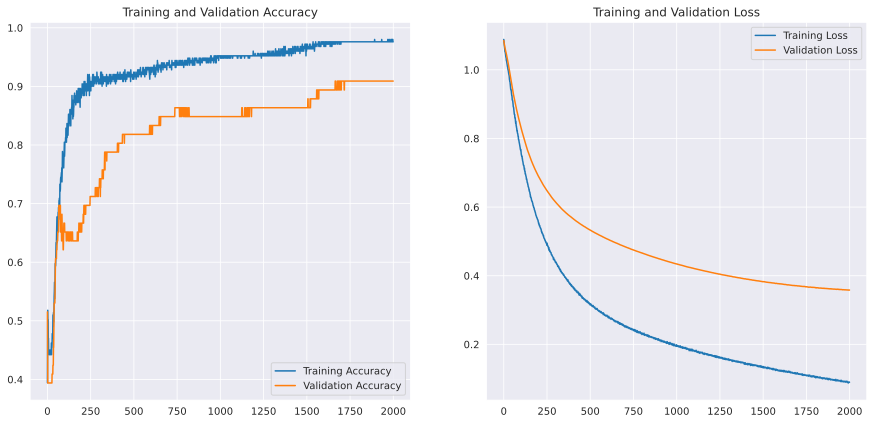

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'


acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(len(acc))  # <-- This adapts to actual training length

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

Viral Pneumonia       0.50      0.08      0.13        26
         Normal       0.00      0.00      0.00        20
          Covid       0.31      0.95      0.46        20

       accuracy                           0.32        66
      macro avg       0.27      0.34      0.20        66
   weighted avg       0.29      0.32      0.19        66

                      Predicted Viral Pneumonia  Predicted Normal  \
True Viral Pneumonia                          2                 0   
True Normal                                   1                 0   
True Covid                                    1                 0   

                      Predicted Covid  
True Viral Pneumonia               24  
True Normal                        19  
True Covid                         19  


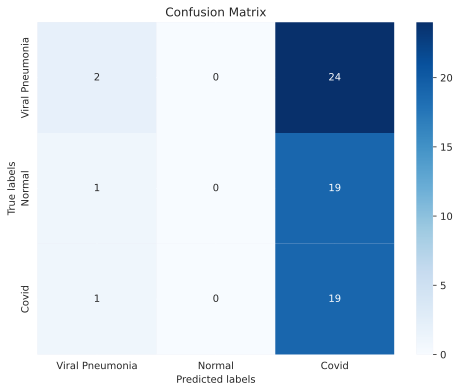

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions (as class indices)
pred_probs = model.predict(x_val)
predictions = np.argmax(pred_probs, axis=1)

# Ensure shapes match
y_val = np.array(y_val).flatten()
predictions = predictions[:len(y_val)]  # Clip excess predictions

# Get class names in correct label order
lab_sorted = dict(sorted(lab.items(), key=lambda item: item[1]))
class_names = list(lab_sorted.keys())

# Classification report
print(classification_report(y_val, predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_val, predictions)
cm_df = pd.DataFrame(cm,
                     index=[f"True {s}" for s in class_names],
                     columns=[f"Predicted {s}" for s in class_names])
print(cm_df)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print("Model input shape:", model.input_shape)


Model input shape: (None, 224, 224, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train = datagen.flow_from_directory(
    "/content/drive/MyDrive/Covid19-dataset/train",
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',  # <--- this is the fix
    class_mode='categorical',
    shuffle=True
)

val = datagen.flow_from_directory(
    "/content/drive/MyDrive/Covid19-dataset/test",
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',  # <--- this too
    class_mode='categorical',
    shuffle=False
)


Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [ ]:
def get_data_from_generator(generator):
    x_data = []
    y_data = []

    for features, labels in generator:
        x_data.append(features)
        y_data.append(np.argmax(labels, axis=1))

        if len(x_data) * generator.batch_size >= generator.samples:
            break

    x_data = np.vstack(x_data)[:generator.samples]
    y_data = np.concatenate(y_data)[:generator.samples]
    return x_data, y_data

x_train, y_train = get_data_from_generator(train)
x_val, y_val = get_data_from_generator(val)


In [ ]:
train_preds = np.argmax(model.predict(x_train), axis=1)
val_preds = np.argmax(model.predict(x_val), axis=1)

scores_train = np.mean(train_preds == y_train)
scores_test = np.mean(val_preds == y_val)

print('Training DataSet accuracy: {: .1%}'.format(scores_train),
      'Test DataSet accuracy: {: .1%}'.format(scores_test))


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
Training DataSet accuracy:  27.5% Test DataSet accuracy:  30.3%
